This tutorial is intended to provide a step by step guidance on how to perform webscraping using Python. This is a useful skill to have since it provides a way to extract data from the web into a structured form that can be imported in Python. This skill comes in handy especially in cases in which no API is given to extract the data in a structured manner. In this tutorial I will be using data generated during a 10K race that I participated in last year (June 2017) 
in Hillsboro, Oregon. I wanted to analyze the performance of the 10K runners and answer simple questions such as, what was the average chip time for the runners, any performance differences between males/females or various age groups, did the chip times follow a normal distribution, etc. I also perform some data cleaning to transform the data into a form I can work with to compute statistics and visualize.

I use Jupyter Notebook and start by importing the necessary modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

To perform webscraping, I import the following libraries.

In [2]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

I then specify the URL containing the data and get the html of the page.

In [3]:
url = "http://www.hubertiming.com/results/2017GPTR10K"
html = urlopen(url)

Getting the html of the page is just the first step. Next step is to use the BeautifulSoup package to parse the html, that is, take the raw html text and break it into Python objects. The second argument 'lxml' is the html parser whose details you do not need to worry about at this point.

In [4]:
soup = BeautifulSoup(html, 'lxml')
type(soup)

bs4.BeautifulSoup

In [5]:
# Useful documentation page: http://2017.compciv.org/guide/topics/python-nonstandard-libraries/beautifulsoup.html

The soup object allows you to extract interesting information about the website you're scraping.

In [6]:
# Get the title
title = soup.title
print(title)

<title>2017 Intel Great Place to Run 10K \ Urban Clash Games Race Results</title>


In [7]:
# Print out the text without HTML code
# print(soup.text)
text = soup.get_text()  # This accomplishes same outcome as soup.text
#print(soup.text)

In [8]:
# You can also print out a nicely formatted HTML content of the page
# print(soup.prettify())

I use the find_all() method of soup to extract the "a" tag of the html. This is the anchor tag that shows all hyperlinks to other web pages

In [9]:
soup.find_all('a')

[<a class="btn btn-primary btn-lg" href="/results/2017GPTR" role="button">5K</a>,
 <a href="http://hubertiming.com/">Huber Timing Home</a>,
 <a href="#individual">Individual Results</a>,
 <a href="#team">Team Results</a>,
 <a href="mailto:timing@hubertiming.com">timing@hubertiming.com</a>,
 <a href="#tabs-1" style="font-size: 18px">Results</a>,
 <a name="individual"></a>,
 <a name="team"></a>,
 <a href="http://www.hubertiming.com/"><img height="65" src="/sites/all/themes/hubertiming/images/clockWithFinishSign_small.png" width="50"/>Huber Timing</a>,
 <a href="http://facebook.com/hubertiming/"><img src="/results/FB-f-Logo__blue_50.png"/></a>]

The output above has multiple attributes for this tag. If interested in printing out only hyperlinks, you can use a for loop and use the get("href") method to extract the hyperlinks

In [10]:
all_links = soup.find_all("a")
for link in all_links:
    print(link.get("href"))

/results/2017GPTR
http://hubertiming.com/
#individual
#team
mailto:timing@hubertiming.com
#tabs-1
None
None
http://www.hubertiming.com/
http://facebook.com/hubertiming/


On this webpage I am interested in the data contained in the table

In [11]:
all_tables = soup.find_all('table')
#print(all_tables)

I use the 'tr' argument to print out table rows only

In [12]:
# Print the first 10 rows for sanity check
rows = soup.find_all('tr')
print(rows[:10])

[<tr><td>Finishers:</td><td>577</td></tr>, <tr><td>Male:</td><td>414</td></tr>, <tr><td>Female:</td><td>163</td></tr>, <tr class="header">
<th>Place</th>
<th>Bib</th>
<th>Name</th>
<th>Gender</th>
<th>City</th>
<th>State</th>
<th>Chip Time</th>
<th>Chip Pace</th>
<th>Gender Place</th>
<th>Age Group</th>
<th>Age Group Place</th>
<th>Time to Start</th>
<th>Gun Time</th>
<th>Team</th>
</tr>, <tr>
<td>1</td>
<td>814</td>
<td>JARED WILSON</td>
<td>M</td>
<td>TIGARD</td>
<td>OR</td>
<td>00:36:21</td>
<td>05:51</td>
<td>1 of 414</td>
<td>M 36-45</td>
<td>1 of 152</td>
<td>00:00:03</td>
<td>00:36:24</td>
<td></td>
</tr>, <tr>
<td>2</td>
<td>573</td>
<td>NATHAN A SUSTERSIC</td>
<td>M</td>
<td>PORTLAND</td>
<td>OR</td>
<td>00:36:42</td>
<td>05:55</td>
<td>2 of 414</td>
<td>M 26-35</td>
<td>1 of 154</td>
<td>00:00:03</td>
<td>00:36:45</td>
<td>INTEL TEAM F</td>
</tr>, <tr>
<td>3</td>
<td>687</td>
<td>FRANCISCO MAYA</td>
<td>M</td>
<td>PORTLAND</td>
<td>OR</td>
<td>00:37:44</td>
<td>06:05</td>
<td

I would like to get all table rows in a list first before converting that list into a DataFrame. For html tags, 'th' defines header cell in table, 'tr' row, 'td' defines a cell in a table

In [13]:
for row in rows:
    row_td = row.find_all('td')
print(row_td)
type(row_td)

[<td>14TH</td>, <td>INTEL TEAM M</td>, <td>04:43:23</td>, <td>00:58:59 - DANIELLE CASILLAS</td>, <td>01:02:06 - RAMYA MERUVA</td>, <td>01:17:06 - PALLAVI J SHINDE</td>, <td>01:25:11 - NALINI MURARI</td>]


bs4.element.ResultSet

There are numerous easier ways to remove the html tags. For this tutorial, I use regular expressions to accomplish this. This will require importing the re module

In [14]:
# Build a regular expression that finds all the characters between <> in row_td and replace them with empty string

import re

all_rows = []
for row in rows:
    etha = row.find_all('td')
    text0 = str(etha)
    clean = re.compile('<.*?>')
    clean2 = (re.sub(clean, '',text0))
    all_rows.append(clean2)
    print(clean2)
type(clean2)

[Finishers:, 577]
[Male:, 414]
[Female:, 163]
[]
[1, 814, JARED WILSON, M, TIGARD, OR, 00:36:21, 05:51, 1 of 414, M 36-45, 1 of 152, 00:00:03, 00:36:24, ]
[2, 573, NATHAN A SUSTERSIC, M, PORTLAND, OR, 00:36:42, 05:55, 2 of 414, M 26-35, 1 of 154, 00:00:03, 00:36:45, INTEL TEAM F]
[3, 687, FRANCISCO MAYA, M, PORTLAND, OR, 00:37:44, 06:05, 3 of 414, M 46-55, 1 of 64, 00:00:04, 00:37:48, ]
[4, 623, PAUL MORROW, M, BEAVERTON, OR, 00:38:34, 06:13, 4 of 414, M 36-45, 2 of 152, 00:00:03, 00:38:37, ]
[5, 569, DEREK G OSBORNE, M, HILLSBORO, OR, 00:39:21, 06:20, 5 of 414, M 26-35, 2 of 154, 00:00:03, 00:39:24, INTEL TEAM F]
[6, 642, JONATHON TRAN, M, PORTLAND, OR, 00:39:49, 06:25, 6 of 414, M 18-25, 1 of 34, 00:00:06, 00:39:55, ]
[7, 144, GEORGE TOTONCHY, M, PORTLAND, OR, 00:40:04, 06:27, 7 of 414, M 36-45, 3 of 152, 00:00:13, 00:40:17, ]
[8, 395, BENJAMIN C CHAFFIN, M, PORTLAND, OR, 00:40:05, 06:27, 8 of 414, M 36-45, 4 of 152, 00:00:04, 00:40:09, ]
[9, 7, BRANDON THOMAS, M, , , 00:40:17, 06:29

[186, 129, KARL H AMSPACHER, M, HILLSBORO, OR, 00:53:06, 08:34, 166 of 414, M 26-35, 53 of 154, 00:00:38, 00:53:44, ]
[187, 599, XIAODONG1 YANG, M, PORTLAND, OR, 00:53:09, 08:34, 167 of 414, M 36-45, 63 of 152, 00:01:02, 00:54:11, INTEL TEAM J]
[188, 652, CURTIS J HOFFMAN, M, ALOHA, OR, 00:53:12, 08:34, 168 of 414, M 36-45, 64 of 152, 00:00:55, 00:54:07, ]
[189, 731, ROBERT HEUSSNER, M, PORTLAND, OR, 00:53:16, 08:35, 169 of 414, M 46-55, 30 of 64, 00:00:38, 00:53:54, ]
[190, 767, ROBERT EHLERT, M, PORTLAND, OR, 00:53:23, 08:36, 170 of 414, M 36-45, 65 of 152, 00:00:30, 00:53:53, ]
[191, 170, JAYCEE SLACK, F, BEAVERTON, OR, 00:53:26, 08:37, 21 of 163, F 18-25, 4 of 21, 00:00:34, 00:54:00, ]
[192, 610, YATHIN PISSAY, M, HILLSBORO, OR, 00:53:31, 08:38, 171 of 414, M 26-35, 54 of 154, 00:00:21, 00:53:52, ]
[193, 36, AJITHPRASADJAIN ADALAGEREJWALANNA, M, BEAVERTON, OR, 00:53:32, 08:38, 172 of 414, M 26-35, 55 of 154, 00:00:20, 00:53:52, ]
[194, 707, CANDICE L YUCA, F, BEAVERTON, OR, 00:53:3

str

In [15]:
# I now convert the list into a DataFrame
df = pd.DataFrame(all_rows)
df.head(10)

,0
0,"[Finishers:, 577]"
1,"[Male:, 414]"
2,"[Female:, 163]"
3,[]
4,"[1, 814, JARED WILSON, M, TIGARD, OR, 00:36:21..."
5,"[2, 573, NATHAN A SUSTERSIC, M, PORTLAND, OR, ..."
6,"[3, 687, FRANCISCO MAYA, M, PORTLAND, OR, 00:3..."
7,"[4, 623, PAUL MORROW, M, BEAVERTON, OR, 00:38:..."
8,"[5, 569, DEREK G OSBORNE, M, HILLSBORO, OR, 00..."
9,"[6, 642, JONATHON TRAN, M, PORTLAND, OR, 00:39..."


This DataFrame is not in the format I want. To clean it up, I split the "0" column into multiple columns after each comma for each row

In [16]:
df1 = df[0].str.split(',', expand=True)
df1.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,[Finishers:,577],None,None,None,None,None,None,None,None,None,None,None,None
1,[Male:,414],None,None,None,None,None,None,None,None,None,None,None,None
2,[Female:,163],None,None,None,None,None,None,None,None,None,None,None,None
3,[],None,None,None,None,None,None,None,None,None,None,None,None,None
4,[1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,[2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,[3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,[4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,[5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]
9,[6,642,JONATHON TRAN,M,PORTLAND,OR,00:39:49,06:25,6 of 414,M 18-25,1 of 34,00:00:06,00:39:55,]


In [17]:
# DataFrame has 596 rows and 14 columns
df1.shape

(596, 14)

I remove the '[' bracket on column 0

In [18]:
df1[0] = df1[0].str.strip('[')
df1.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Finishers:,577],None,None,None,None,None,None,None,None,None,None,None,None
1,Male:,414],None,None,None,None,None,None,None,None,None,None,None,None
2,Female:,163],None,None,None,None,None,None,None,None,None,None,None,None
3,],None,None,None,None,None,None,None,None,None,None,None,None,None
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]
9,6,642,JONATHON TRAN,M,PORTLAND,OR,00:39:49,06:25,6 of 414,M 18-25,1 of 34,00:00:06,00:39:55,]


The table is missing table headers. I use the find_all() method to get the table headers

In [19]:
col_labels = soup.find_all("th")

Similar to table rows, I use regular expressions to extract text in between html tags

In [20]:
all_header = []
col_str = str(col_labels)
clean = re.compile('<.*?>')
clean3 = (re.sub(clean, '',col_str))
all_header.append(clean3)
print(all_header)

['[Place, Bib, Name, Gender, City, State, Chip Time, Chip Pace, Gender Place, Age Group, Age Group Place, Time to Start, Gun Time, Team]']


In [21]:
df2 = pd.DataFrame(all_header)
df2.head(10)

,0
0,"[Place, Bib, Name, Gender, City, State, Chip T..."


Similarly, I split column "0" into multiple columns after each comma for all rows

In [22]:
df3 = df2[0].str.split(',', expand=True)
df3.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]


I concatenate the 2 DataFrames into one table

In [23]:
frames = [df3, df1]

df4 = pd.concat(frames)
df4.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
0,Finishers:,577],None,None,None,None,None,None,None,None,None,None,None,None
1,Male:,414],None,None,None,None,None,None,None,None,None,None,None,None
2,Female:,163],None,None,None,None,None,None,None,None,None,None,None,None
3,],None,None,None,None,None,None,None,None,None,None,None,None,None
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]


Below I assign the first row to be the table header

In [24]:
df5 = df4.rename(columns=df4.iloc[0])
df5.head(10)

,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
0,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
0,Finishers:,577],None,None,None,None,None,None,None,None,None,None,None,None
1,Male:,414],None,None,None,None,None,None,None,None,None,None,None,None
2,Female:,163],None,None,None,None,None,None,None,None,None,None,None,None
3,],None,None,None,None,None,None,None,None,None,None,None,None,None
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]


In [25]:
# I start by getting an overview of the data
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 595
Data columns (total 14 columns):
[Place              597 non-null object
 Bib                596 non-null object
 Name               593 non-null object
 Gender             593 non-null object
 City               593 non-null object
 State              593 non-null object
 Chip Time          593 non-null object
 Chip Pace          578 non-null object
 Gender Place       578 non-null object
 Age Group          578 non-null object
 Age Group Place    578 non-null object
 Time to Start      578 non-null object
 Gun Time           578 non-null object
 Team]              578 non-null object
dtypes: object(14)
memory usage: 70.0+ KB


In [26]:
# I drop all rows with any missing values
df6 = df5.dropna(axis=0, how='any')
df6.head(10)

,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
0,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]
9,6,642,JONATHON TRAN,M,PORTLAND,OR,00:39:49,06:25,6 of 414,M 18-25,1 of 34,00:00:06,00:39:55,]
10,7,144,GEORGE TOTONCHY,M,PORTLAND,OR,00:40:04,06:27,7 of 414,M 36-45,3 of 152,00:00:13,00:40:17,]
11,8,395,BENJAMIN C CHAFFIN,M,PORTLAND,OR,00:40:05,06:27,8 of 414,M 36-45,4 of 152,00:00:04,00:40:09,]
12,9,7,BRANDON THOMAS,M,,,00:40:17,06:29,9 of 414,M 26-35,3 of 154,00:00:07,00:40:24,COLUMBIA TEAM B]


In [27]:
# Notice that the table header is replicated as the first row, so I drop it
df7 = df6.drop(df6.index[0])
df7.head(10)

,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]
9,6,642,JONATHON TRAN,M,PORTLAND,OR,00:39:49,06:25,6 of 414,M 18-25,1 of 34,00:00:06,00:39:55,]
10,7,144,GEORGE TOTONCHY,M,PORTLAND,OR,00:40:04,06:27,7 of 414,M 36-45,3 of 152,00:00:13,00:40:17,]
11,8,395,BENJAMIN C CHAFFIN,M,PORTLAND,OR,00:40:05,06:27,8 of 414,M 36-45,4 of 152,00:00:04,00:40:09,]
12,9,7,BRANDON THOMAS,M,,,00:40:17,06:29,9 of 414,M 26-35,3 of 154,00:00:07,00:40:24,COLUMBIA TEAM B]
13,10,3,ERIK BJORNSTAD,M,,,00:40:21,06:30,10 of 414,M 36-45,5 of 152,00:00:04,00:40:25,COLUMBIA TEAM A]


In [28]:
# I rename Place
df7.rename(columns={'[Place': 'Place'},inplace=True)
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]


In [29]:
# I also rename Team
df7.rename(columns={'Team]': 'Team'},inplace=True)
df7.rename(columns={' Team]': 'Team'},inplace=True) # Python is very picky about space. Make sure you put space in ' Team]'
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]


In [30]:
df7.columns

Index(['Place', ' Bib', ' Name', ' Gender', ' City', ' State', ' Chip Time',
       ' Chip Pace', ' Gender Place', ' Age Group', ' Age Group Place',
       ' Time to Start', ' Gun Time', 'Team'],
      dtype='object')

Final data cleaning step involves removing closing bracket for strings in "Team" column. The DataFrame is now in a format I like. Now I can start plotting the data and computing statistics

In [31]:
df7['Team'] = df7['Team'].str.strip(']')
df7.head(10)

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F
9,6,642,JONATHON TRAN,M,PORTLAND,OR,00:39:49,06:25,6 of 414,M 18-25,1 of 34,00:00:06,00:39:55,
10,7,144,GEORGE TOTONCHY,M,PORTLAND,OR,00:40:04,06:27,7 of 414,M 36-45,3 of 152,00:00:13,00:40:17,
11,8,395,BENJAMIN C CHAFFIN,M,PORTLAND,OR,00:40:05,06:27,8 of 414,M 36-45,4 of 152,00:00:04,00:40:09,
12,9,7,BRANDON THOMAS,M,,,00:40:17,06:29,9 of 414,M 26-35,3 of 154,00:00:07,00:40:24,COLUMBIA TEAM B
13,10,3,ERIK BJORNSTAD,M,,,00:40:21,06:30,10 of 414,M 36-45,5 of 152,00:00:04,00:40:25,COLUMBIA TEAM A


In [32]:
print(df7.dtypes)

Place               object
 Bib                object
 Name               object
 Gender             object
 City               object
 State              object
 Chip Time          object
 Chip Pace          object
 Gender Place       object
 Age Group          object
 Age Group Place    object
 Time to Start      object
 Gun Time           object
Team                object
dtype: object


I create a column 'Runner_mins' that converts Chip Time into total minutes. I am sure there is an easier way to do the conversion. I prefer to convert the Chip Time to list first and convert the list into DataFrame again.

In [33]:
time_list = df7[' Chip Time'].tolist()

# I use a for loop to convert Chip Time to minutes

time_mins = []
for i in time_list:
    h, m, s = i.split(':')
    math = (int(h) * 3600 + int(m) * 60 + int(s))/60
    time_mins.append(math)
#print(time_mins)

In [34]:
# I convert this list to DataFrame

df7['Runner_mins'] = time_mins
df7.head(10)

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team,Runner_mins
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,,36.350000
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F,36.700000
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,,37.733333
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,,38.566667
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F,39.350000
9,6,642,JONATHON TRAN,M,PORTLAND,OR,00:39:49,06:25,6 of 414,M 18-25,1 of 34,00:00:06,00:39:55,,39.816667
10,7,144,GEORGE TOTONCHY,M,PORTLAND,OR,00:40:04,06:27,7 of 414,M 36-45,3 of 152,00:00:13,00:40:17,,40.066667
11,8,395,BENJAMIN C CHAFFIN,M,PORTLAND,OR,00:40:05,06:27,8 of 414,M 36-45,4 of 152,00:00:04,00:40:09,,40.083333
12,9,7,BRANDON THOMAS,M,,,00:40:17,06:29,9 of 414,M 26-35,3 of 154,00:00:07,00:40:24,COLUMBIA TEAM B,40.283333
13,10,3,ERIK BJORNSTAD,M,,,00:40:21,06:30,10 of 414,M 36-45,5 of 152,00:00:04,00:40:25,COLUMBIA TEAM A,40.350000


In [35]:
# Runner_mins is of float datatype
df7['Runner_mins'].dtype

dtype('float64')

In [36]:
# Below I calculate statistics of numeric columns only in DataFrame. 
df7.describe(include=[np.number])

# This is interesting. The fastest 10K runner finished in 36.35 mins and the slowest in 101.3 minutes

,Runner_mins
count,577.000000
mean,60.035933
std,11.970623
min,36.350000
25%,51.000000
50%,59.016667
75%,67.266667
max,101.300000


In [37]:
# For data visualization i import rcParams from pylab and set figure size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

I use a barplot to plot runners' Chip Times in ascending Order

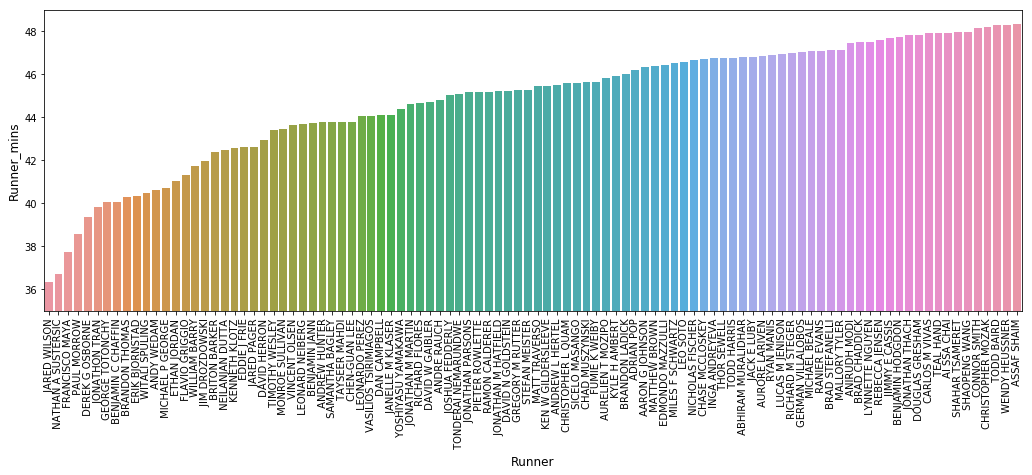

In [38]:
bp_runners = sns.barplot(x=" Name", y="Runner_mins", data=df7[:100])
plt.ylim(35, 49)
plt.xlabel('Runner', fontsize=12)
plt.ylabel('Runner_mins', fontsize=12)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

Interestingly, there is a larger difference in chip times between the top 6 performing runners
compared to the slower runners

([<matplotlib.axis.XTick at 0x74a566cf28>],
 <a list of 1 Text xticklabel objects>)

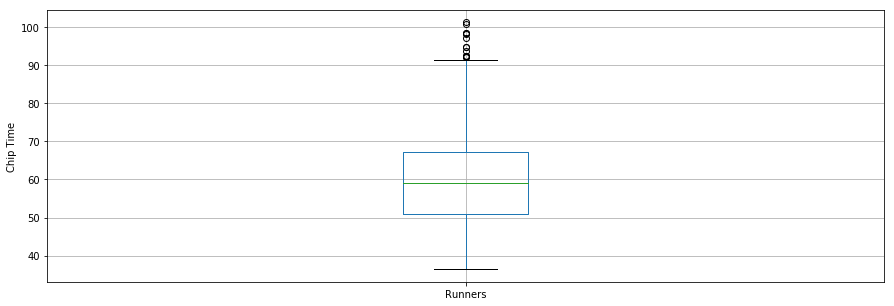

In [39]:
# A boxplot is a good way visualise summary statistics (median, maximum, minimun, first quartile, third quartile) including outliers.
df7.boxplot(column='Runner_mins')
plt.grid(True, axis='y')
plt.ylabel('Chip Time')
plt.xticks([1], ['Runners'])

Boxplot shows some outliers among some of the slower runners. I was curious to visualize the barplot of their
chip times. Barplot shows some bigger differences in chip times between the last 40 runners or so. See below

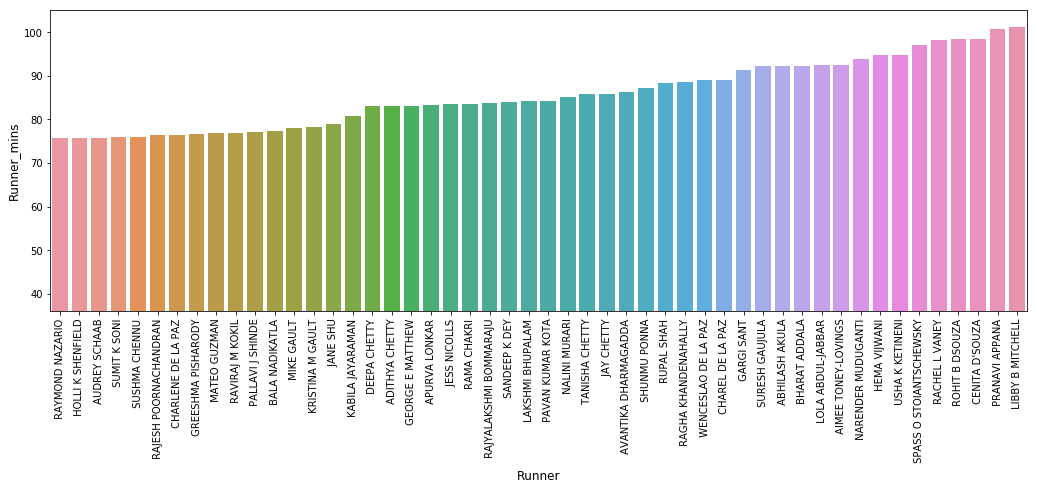

In [40]:
bp_runners = sns.barplot(x=" Name", y="Runner_mins", data=df7[527:])
plt.ylim(36, 105)
plt.xlabel('Runner', fontsize=12)
plt.ylabel('Runner_mins', fontsize=12)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

Below I plot a bargraph showing counts of participants categorized by age group

[Text(0,0,' M 36-45'),
 Text(0,0,' M 26-35'),
 Text(0,0,' M 46-55'),
 Text(0,0,' M 18-25'),
 Text(0,0,' F 18-25'),
 Text(0,0,' F 26-35'),
 Text(0,0,' F 36-45'),
 Text(0,0,' F Under 18'),
 Text(0,0,' F 46-55'),
 Text(0,0,' '),
 Text(0,0,' M Under 18'),
 Text(0,0,' M 55+')]

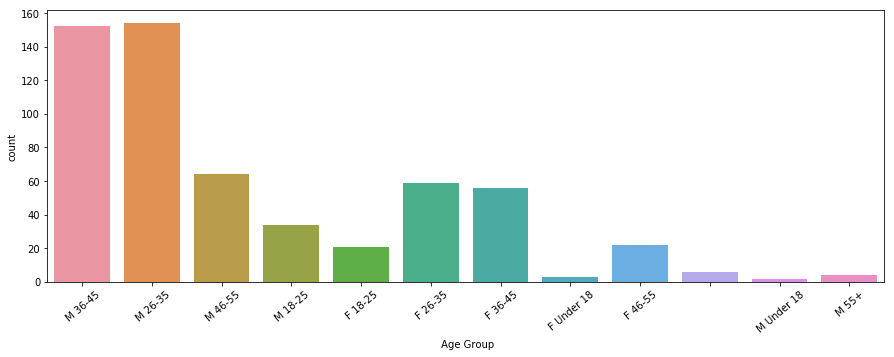

In [41]:
umnyaka = sns.countplot(x=" Age Group", data=df7)
umnyaka.set_xticklabels(umnyaka.get_xticklabels(), rotation=40)

Distribution plot of Chip Times for all runners. The distribution looks almost normal.

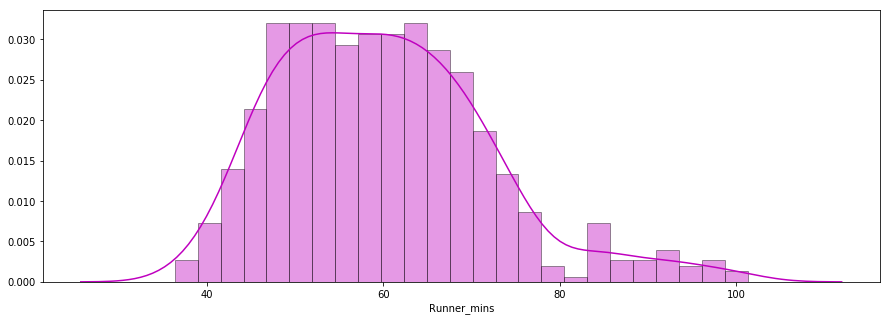

In [42]:
x = df7['Runner_mins']
ax = sns.distplot(x, hist=True, kde=True, rug=False, color='m', bins=25, hist_kws={'edgecolor':'black'})
plt.show()

Distribution plot of Chip Times for Males and Females

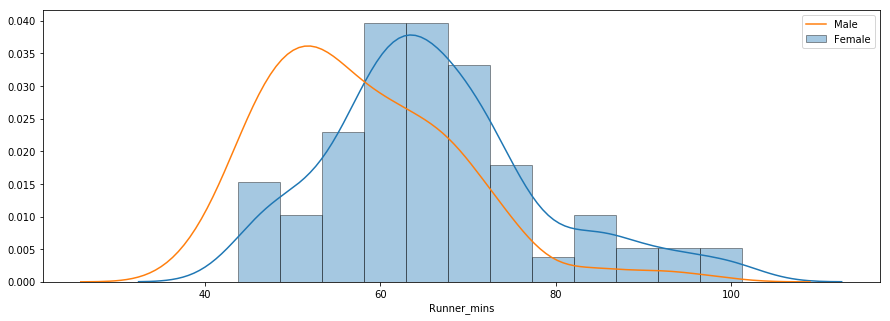

In [54]:
sns.distplot(f_fuko, hist=True, kde=True, rug=False, hist_kws={'edgecolor':'black'}, label='Female')
sns.distplot(m_fuko, hist=False, kde=True, rug=False, hist_kws={'edgecolor':'black'}, label='Male')
plt.legend()

Compute stats for males and females separated

In [45]:
g_stats = df7.groupby(" Gender", as_index=True).describe()
print(g_stats)

        Runner_mins                                                         \
              count       mean        std        min        25%        50%   
 Gender                                                                      
 F            163.0  66.119223  12.184440  43.766667  58.758333  64.616667   
 M            414.0  57.640821  11.011857  36.350000  49.395833  55.791667   

                                
               75%         max  
 Gender                         
 F       72.058333  101.300000  
 M       64.804167   98.516667  


C:\Users\smasango\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,0.98,'')

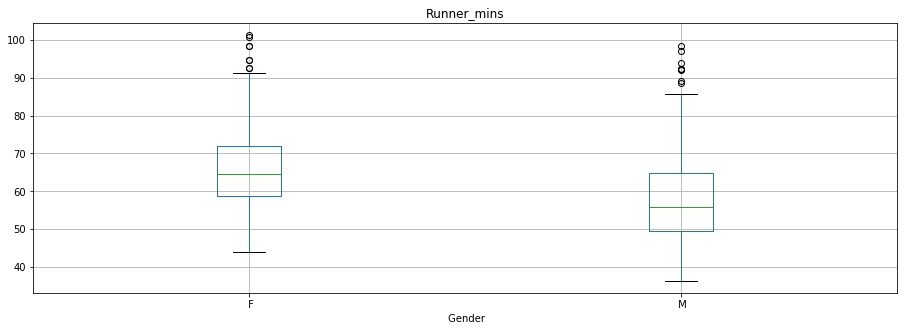

In [46]:
df7.boxplot(column='Runner_mins', by=' Gender')
plt.suptitle("")

C:\Users\smasango\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0,0.5,'Runner_mins')

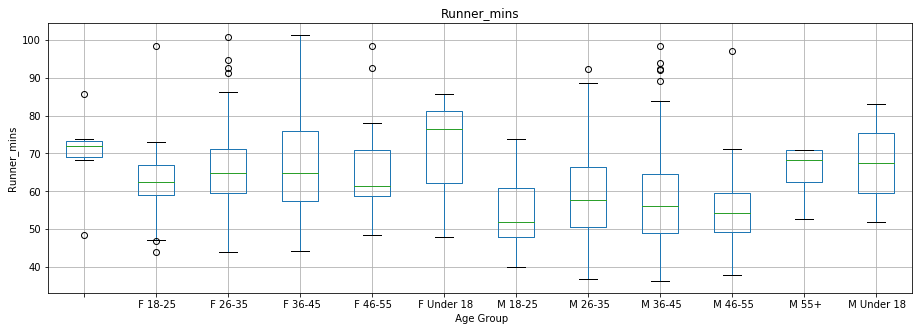

In [47]:
df7.boxplot(column='Runner_mins', by=' Age Group')
plt.suptitle("")
plt.ylabel('Runner_mins')

In [48]:
c_stats = df7.groupby(" Age Group", as_index=True).describe()
print(c_stats)

            Runner_mins                                              \
                  count       mean        std        min        25%   
 Age Group                                                            
                    6.0  70.025000  12.151419  48.483333  69.125000   
 F 18-25           21.0  62.811111  11.390022  43.766667  58.966667   
 F 26-35           59.0  66.637853  11.478642  43.783333  59.616667   
 F 36-45           56.0  66.720536  13.110867  44.116667  57.404167   
 F 46-55           22.0  65.458333  12.387578  48.300000  58.700000   
 F Under 18         3.0  70.066667  19.707803  47.966667  62.191667   
 M 18-25           34.0  54.277451   8.698495  39.816667  47.845833   
 M 26-35          154.0  58.649784  10.778619  36.700000  50.420833   
 M 36-45          152.0  57.776754  11.803281  36.350000  48.854167   
 M 46-55           64.0  55.136719   9.218254  37.733333  49.308333   
 M 55+              4.0  65.025000   8.678950  52.566667  62.354167   
 M Und

Compute and visualize the difference in chip times between a runner and the one ahead of them

In [49]:
df7['diff_runner'] = df7['Runner_mins'].diff()
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team,Runner_mins,diff_runner
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,,36.350000,NaN
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F,36.700000,0.350000
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,,37.733333,1.033333
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,,38.566667,0.833333
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F,39.350000,0.783333


In [50]:
# Remove missing "NaN" rows
df7.dropna(axis=0, how='any').head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team,Runner_mins,diff_runner
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F,36.700000,0.350000
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,,37.733333,1.033333
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,,38.566667,0.833333
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F,39.350000,0.783333
9,6,642,JONATHON TRAN,M,PORTLAND,OR,00:39:49,06:25,6 of 414,M 18-25,1 of 34,00:00:06,00:39:55,,39.816667,0.466667


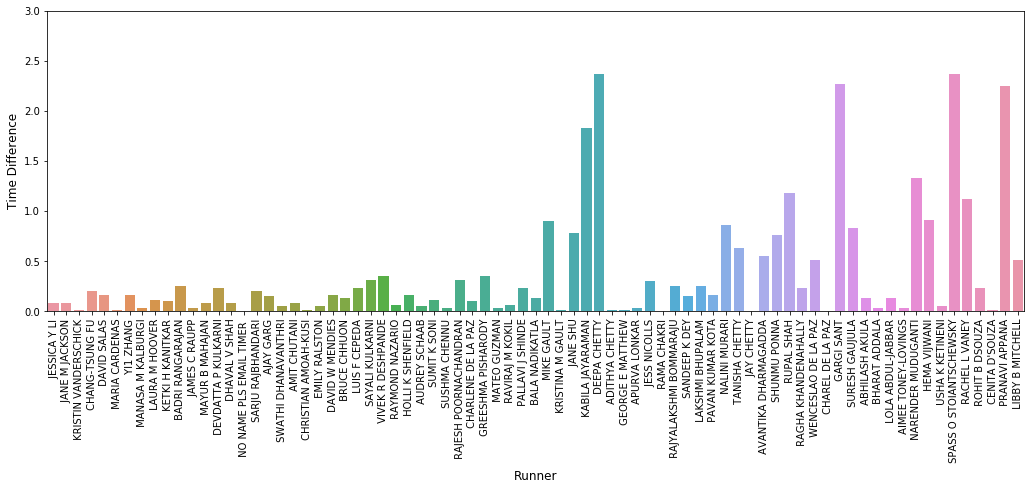

In [51]:
runner_td = sns.barplot(x=" Name", y="diff_runner", data=df7[500:])
plt.ylim(0, 3)
plt.xlabel('Runner', fontsize=12)
plt.ylabel('Time Difference', fontsize=12)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

How slow were the runners behind the fastest 10K runner? He finished in 36.35 minutes.

In [52]:
df7['time_behind'] = df7['Runner_mins'] - 36.35
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team,Runner_mins,diff_runner,time_behind
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,,36.350000,NaN,0.000000
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F,36.700000,0.350000,0.350000
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,,37.733333,1.033333,1.383333
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,,38.566667,0.833333,2.216667
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F,39.350000,0.783333,3.000000


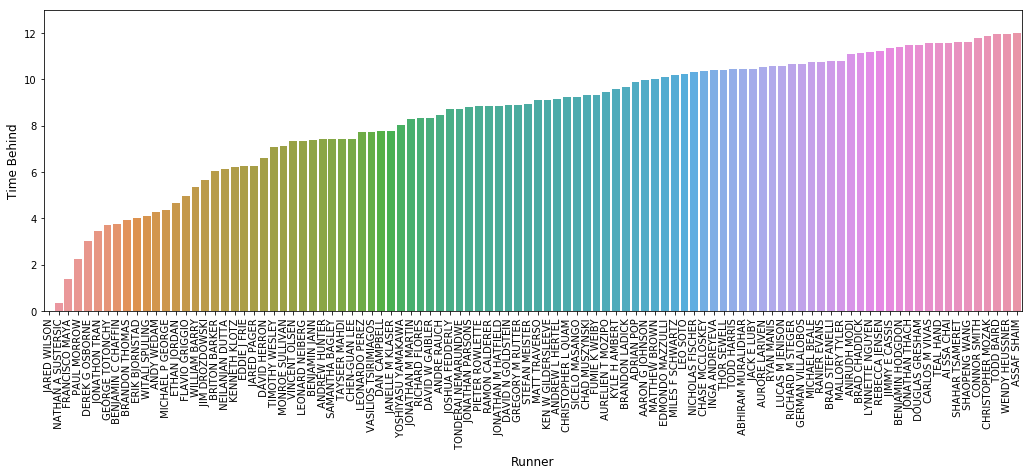

In [53]:
runner_timebehind = sns.barplot(x=" Name", y="time_behind", data=df7[:100])
plt.ylim(0, 13)
plt.xlabel('Runner', fontsize=12)
plt.ylabel('Time Behind', fontsize=12)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()